## Genetic manipulation

### Import the required libraries and the model.

In [453]:
### Import the required libraries and the model.
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
from cameo import phenotypic_phase_plane
from cameo.strain_design.heuristic.evolutionary_based import OptGene
from cameo.strain_design.deterministic.linear_programming import OptKnock
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cobra.flux_analysis.moma import moma
plotter = PlotlyPlotter()
import matplotlib.pyplot as plt
%matplotlib inline
from pytest import approx
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas as pd
import numpy as np
import cobra
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline


model = read_sbml_model('2018_ATCC1015_GSM_iJB1325.xml') #The model is refered from (Brandl, J., Aguilar-Pontes, M. V., Schape, P., Norregaard, A., Arvas, M., Ram, A. F. J., Meyer, V., Tsang, A., de Vries, R. P., & Andersen, M. R. (2018). A community-driven reconstruction of the Aspergillus niger metabolic network. Fungal Biology and Biotechnology, 5, 16. )

'' is not a valid SBML 'SId'.


### Media setup

In [454]:
#Add extracellular metanolites
PNTOe = Metabolite('PNTOe', formula='C9H17NO5', name='(R)-Pantothenate', compartment='e') 
model.add_metabolites([PNTOe])

DHFe = Metabolite('DHFe', formula='C19H21N7O6', name='7,8-Dihydrofolate', compartment='e') 
model.add_metabolites([DHFe])

PABAe = Metabolite('PABAe', formula='C7H7NO2', name='4-Aminobenzoate', compartment='e') 
model.add_metabolites([PABAe])

PLe = Metabolite('PLe', formula='C8H9NO3', name='Pyridoxal', compartment='e') 
model.add_metabolites([PLe])

RIBOFLAVe = Metabolite('RIBOFLAVe', formula='C17H20N4O6', name='Riboflavin', compartment='e') 
model.add_metabolites([RIBOFLAVe])

#Add transport reactions
r2392 = Reaction('r2392')
r2392.name = '(R)-Pantothenate transport'
r2392.subsystem = "Transport"
r2392.lower_bound = -1000
r2392.add_metabolites({PNTOe: -1.0, model.metabolites.PNTO: 1.0})

r2393 = Reaction('r2393')
r2393.name = '7,8-Dihydrofolate transport'
r2393.lower_bound = -1000
r2393.subsystem = 'Transport'
r2393.add_metabolites({DHFe: -1.0, model.metabolites.DHF: 1.0})

r2394 = Reaction('r2394')
r2394.name = '4-Aminobenzoate transport'
r2394.lower_bound = -1000
r2394.subsystem = 'Transport'
r2394.add_metabolites({PABAe: -1.0, model.metabolites.PABA: 1.0})

r2395 = Reaction('r2395')
r2395.name = 'Pyridoxal transport'
r2395.lower_bound = -1000
r2395.subsystem = 'Transport'
r2395.add_metabolites({PLe: -1.0, model.metabolites.PL: 1.0})

r2396 = Reaction('r2396')
r2396.name = 'Riboflavin transport'
r2396.lower_bound = -1000
r2396.subsystem = 'Transport'
r2396.add_metabolites({RIBOFLAVe: -1.0, model.metabolites.RIBOFLAV: 1.0})

r2397 = Reaction('r2397')
r2397.name = 'Copper transport'
r2397.lower_bound = -1000
r2397.subsystem = 'Transport'
r2397.add_metabolites({model.metabolites.CUe: -1.0, model.metabolites.CU: 1.0})

#Add boundary conditions
model.add_boundary(model.metabolites.PNTOe, type="exchange", reaction_id= "BOUNDARY_PNTOe")
model.add_boundary(model.metabolites.DHFe, type="exchange", reaction_id= "BOUNDARY_DHFe")
model.add_boundary(model.metabolites.PABAe, type="exchange", reaction_id= "BOUNDARY_PABAe")
model.add_boundary(model.metabolites.PLe, type="exchange", reaction_id= "BOUNDARY_PLe")
model.add_boundary(model.metabolites.RIBOFLAVe, type="exchange", reaction_id= "BOUNDARY_RIBOFLAVe")
model.add_boundary(model.metabolites.CUe, type="exchange", reaction_id= "BOUNDARY_CUe")

medium_blank = {key: 0 for key in model.medium}
YESmedium = medium_blank # Setup the object for YESmedium

#Set the concentration for the amino acids
YESmedium['BOUNDARY_GLCe'] = 20 
# YESmedium['BOUNDARY_ALAe'] = 10
YESmedium['BOUNDARY_ARGe'] = 10
# YESmedium['BOUNDARY_ASPe'] = 10
# YESmedium['BOUNDARY_CYSe'] = 10
# YESmedium['BOUNDARY_GLUe'] = 10
# YESmedium['BOUNDARY_GLYe'] = 10
# YESmedium['BOUNDARY_HISe'] = 10
# YESmedium['BOUNDARY_ILEe'] = 10
# YESmedium['BOUNDARY_LEUe'] = 10
# YESmedium['BOUNDARY_LYSe'] = 10
# YESmedium['BOUNDARY_METe'] = 10
# YESmedium['BOUNDARY_PHEe'] = 10
# YESmedium['BOUNDARY_PROe'] = 10
# YESmedium['BOUNDARY_SERe'] = 10
# YESmedium['BOUNDARY_THRe'] = 10
# YESmedium['BOUNDARY_TRPe'] = 10
# YESmedium['BOUNDARY_TYRe'] = 10
# YESmedium['BOUNDARY_VALe'] = 10

#Set the concentration for the supplements
YESmedium['BOUNDARY_NH4e'] = 5 #Ammonium  
YESmedium['BOUNDARY_SLFe'] = 5.5 #Sulfate
YESmedium['BOUNDARY_BTe'] = 2/10**6 #Biotin 
YESmedium['BOUNDARY_PNTOe'] = 400/10**6 #Pantothenic Acid
YESmedium['BOUNDARY_DHFe'] = 2/10**6 #Folic acid
YESmedium['BOUNDARY_MYOIe'] = 4000/10**6 #myo-Inositol
YESmedium['BOUNDARY_NICAe'] = 800/10**6 #Nicotinate
YESmedium['BOUNDARY_PABAe'] = 400/10**6 #4-Aminobenzoate
YESmedium['BOUNDARY_PLe'] = 800/10**6 #Pyridoxal
YESmedium['BOUNDARY_RIBOFLAVe'] = 200/10**6 #Riboflavin
YESmedium['BOUNDARY_THIAe'] = 800/10**6 #Thiamine
YESmedium['BOUNDARY_CUe'] = 80/10**6 #Copper
YESmedium['BOUNDARY_Ke'] = 2 #Potassium
YESmedium['BOUNDARY_FE2e'] = 200/10**6 #Ferric 
YESmedium['BOUNDARY_MNe'] = 400/10**6 #Manganese
YESmedium['BOUNDARY_MOe'] = 200/10**6 #Molybdate
YESmedium['BOUNDARY_ZNe'] = 400/10**6 #Zinc
YESmedium['BOUNDARY_PIe'] = 0 #Phosphate
YESmedium['BOUNDARY_CAe'] = 0.4 #Calcium 

#Set the condition
YESmedium['BOUNDARY_H2Oe'] = 1000 #Water
YESmedium['BOUNDARY_O2e'] = 1000 #Oxygen 

# Setting YES as control medium
model.medium = YESmedium

model.reactions.BOUNDARY_GLCe.bonds = -20,0

#### Computing the summed carbon source fluxes: 

In [455]:
# Revised the bojective value
model.objective = model.reactions.r1976
solution = model.optimize()

CSource_fluxes = [model.reactions.BOUNDARY_ALAe.flux,
       model.reactions.BOUNDARY_ARGe.flux,
       model.reactions.BOUNDARY_ASPe.flux,
       model.reactions.BOUNDARY_CYSe.flux,
       model.reactions.BOUNDARY_GLUe.flux,
       model.reactions.BOUNDARY_GLYe.flux,
       model.reactions.BOUNDARY_HISe.flux,
       model.reactions.BOUNDARY_ILEe.flux,
       model.reactions.BOUNDARY_LEUe.flux,
       model.reactions.BOUNDARY_LYSe.flux,
       model.reactions.BOUNDARY_METe.flux,
       model.reactions.BOUNDARY_PHEe.flux,
       model.reactions.BOUNDARY_PROe.flux,
       model.reactions.BOUNDARY_SERe.flux,
       model.reactions.BOUNDARY_THRe.flux,
       model.reactions.BOUNDARY_TRPe.flux,
       model.reactions.BOUNDARY_TYRe.flux,
       model.reactions.BOUNDARY_VALe.flux,
       model.reactions.BOUNDARY_GLCe.flux ]

sum_CSource_fluxes = sum(CSource_fluxes)

### Knockout

In [456]:
#Setting up the model
model_KO=model.copy()
#changing source to sucrose
model_KO.medium = YESmedium



In [272]:
#Wild type
with model_KO:
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = -5.3906791731186485e-12 mmol/gDW*h
Maximum theoretical yield = -1.7968930577062162e-13 mmol-yanD/mmol-Csources


In [284]:
#R32c knockout
with model_KO:
    model_KO.reactions.r32c.knock_out()
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 6.962960598603464e-12 mmol/gDW*h
Maximum theoretical yield = 2.3209868662011544e-13 mmol-yanD/mmol-Csources


In [288]:
#R33c knockout
with model_KO:
     model_KO.reactions.r33c.knock_out()
   
     model_KO.objective = model_KO.reactions.r1976
    
   
   
     yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
     growth = max(yanD.data_frame["DRAIN_Biomass"])
     yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
     print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
     maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
     print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
     #Visualization
     yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 2.0215046899173313e-11 mmol/gDW*h
Maximum theoretical yield = 6.738348966391104e-13 mmol-yanD/mmol-Csources


In [294]:
#R545 knockout
with model_KO:
    model_KO.reactions.r545.knock_out()
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 3.385548287033902 mmol/gDW*h
Maximum theoretical yield = 0.11285160956779673 mmol-yanD/mmol-Csources


### Overexpression

In [345]:
#R1147 OE
with model_KO:
    model_KO.reactions.r1147.bounds = 10,1000
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = -5.8508455575800624e-09 mmol/gDW*h
Maximum theoretical yield = -1.9502818525266876e-10 mmol-yanD/mmol-Csources


In [344]:
#R862 OE
with model_KO:
    model_KO.reactions.r862.bounds = 10,1000
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 2.4552929288107888 mmol/gDW*h
Maximum theoretical yield = 0.0818430976270263 mmol-yanD/mmol-Csources


In [343]:
#R861 OE
with model_KO:
    model_KO.reactions.r861.bounds = 10,1000
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 2.4552929287614056 mmol/gDW*h
Maximum theoretical yield = 0.08184309762538018 mmol-yanD/mmol-Csources


In [342]:
#R671 OE
with model_KO:
    model_KO.reactions.r671.bounds = 10,1000
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 2.4552929289997962 mmol/gDW*h
Maximum theoretical yield = 0.08184309763332655 mmol-yanD/mmol-Csources


In [354]:
#R864 OE
with model_KO:
    model_KO.reactions.r864.bounds = 10,1000
    model_KO.objective = model_KO.reactions.r1976
    
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 7.636296158616023e-09 mmol/gDW*h
Maximum theoretical yield = 2.5454320528720077e-10 mmol-yanD/mmol-Csources


### Proposed approach

In [365]:
#R864 OE
with model_KO:
    model_KO.reactions.r862.bounds = 10,1000
   
   
   
    yanD = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')
    growth = max(yanD.data_frame["DRAIN_Biomass"])
    yanD_production = yanD.data_frame.loc[yanD.data_frame["DRAIN_Biomass"] == growth, "objective_upper_bound"].iloc[0]
   
    print('Maximum productivity =', yanD_production, 'mmol/gDW*h')
   
    maximum_yield_YEPD = yanD_production / (-1*(sum_CSource_fluxes))
    print('Maximum theoretical yield =', maximum_yield_YEPD, 'mmol-yanD/mmol-Csources')
    #Visualization
    yanD.plot(plotter, points=[(growth, yanD_production)])

Maximum productivity = 2.4552929287573666 mmol/gDW*h
Maximum theoretical yield = 0.08184309762524555 mmol-yanD/mmol-Csources


In [457]:
#WT
yanD_WT = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')

#MT
model_KO.reactions.r862.bounds = 10,1000
yanD_MT = phenotypic_phase_plane(model_KO, variables=['DRAIN_Biomass'], objective='r1976')



### MOMA

In [459]:
#MOMA
model_KO.objective = model_KO.reactions.DRAIN_Biomass
moma_sol = moma(model_KO)

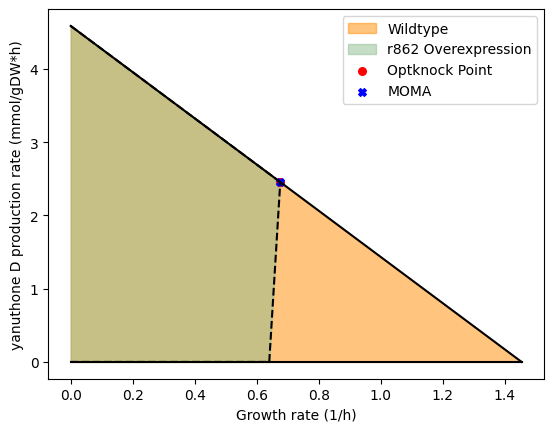

In [460]:
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named df
Optknock = (0.675,2.455)
plt.plot(yanD_WT['DRAIN_Biomass'], yanD_WT['objective_lower_bound'], color="black")
plt.plot(yanD_WT['DRAIN_Biomass'], yanD_WT['objective_upper_bound'], color="black")
plt.fill_between(yanD_WT['DRAIN_Biomass'], yanD_WT['objective_lower_bound'], yanD_WT['objective_upper_bound'], color='darkorange', alpha=0.5, label='Wildtype')

plt.plot(yanD_MT['DRAIN_Biomass'], yanD_MT['objective_lower_bound'], color="black", linestyle='dashed')
plt.plot(yanD_MT['DRAIN_Biomass'], yanD_MT['objective_upper_bound'], color="black", linestyle='dashed')
plt.fill_between(yanD_MT['DRAIN_Biomass'], yanD_MT['objective_lower_bound'], yanD_MT['objective_upper_bound'], color='darkseagreen', alpha=0.5, label='r862 Overexpression')

#Optknock
plt.scatter([Optknock[0]], [Optknock[1]], s=30 ,color='red', marker='o', label='Optknock Point')
#MOMA
plt.scatter([moma_sol["DRAIN_Biomass"]], [moma_sol["r1976"]], s=30 ,color='Blue', marker='X', label='MOMA')



plt.xlabel('Growth rate (1/h)')
plt.ylabel('yanuthone D production rate (mmol/gDW*h)')

plt.legend()
plt.show()
